In [1]:
import os
import re
import pickle
import time
import copy
from functools import partial
from pathlib import Path
from collections import defaultdict

import seaborn as sns
import pandas as pd
import numpy as np
import scipy
from scipy import signal

from tqdm.autonotebook import tqdm

import dask
from dask import dataframe as dd
from dask import delayed
from dask.distributed import Client, LocalCluster, TimeoutError

from IPython.display import display

import matplotlib.pyplot as plt

%load_ext autoreload

%autoreload 2

pd.options.display.max_rows = 5

%load_ext line_profiler
%matplotlib inline

/home/alexis/anaconda3/envs/fastai/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [2]:
FREQUENCY = 10
WINDOW_LENGTH = 20*FREQUENCY
PRED_HORIZON = 5*FREQUENCY

In [14]:
import torch
import torch.utils
import torch.utils.data
import torch.tensor as tt
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import math

from onecyclelr import OneCycleLR
import lr_finder

import mlflow
import mlflow.pytorch

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
def torch_choice(x, size=(1,)):
    return x[torch.randint(low=0, high=len(x), size=size)]
    
sin_channels = 1
class SinDS(torch.utils.data.Dataset):
    def __init__(self, length):
        super().__init__()
        self.length = length
        
    def __getitem__(self, idx):
        x = torch.sin(
            torch.arange(
                WINDOW_LENGTH + PRED_HORIZON, dtype=torch.float32, device=device) 
            * math.pi/20 * torch.randn((sin_channels, 1), device=device) 
            + torch.randint(low=0, high=100, size=(sin_channels, 1), dtype=torch.float32, device=device) 
        + torch.randn((sin_channels, 1), device=device))
        return x[:, :WINDOW_LENGTH], x[:, WINDOW_LENGTH:WINDOW_LENGTH+PRED_HORIZON]
    
    def __len__(self):
        return self.length

In [6]:
class ChannelLinear(torch.nn.Module):
    __constants__ = ['bias']

    def __init__(self, ch_features, in_features, out_features, bias=True):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = torch.nn.Parameter(torch.Tensor(ch_features, in_features, out_features))
        if bias:
            self.bias = torch.nn.Parameter(torch.Tensor(ch_features, out_features))
        else:
            self.register_parameter('bias', None)
        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.weight, a=np.sqrt(5))
        if self.bias is not None:
            fan_in, _ = torch.nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / np.sqrt(fan_in)
            torch.nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return torch.einsum('cij,bci->bcj', self.weight, input) + self.bias

    def extra_repr(self):
        return 'in_features={}, out_features={}, bias={}'.format(
            self.in_features, self.out_features, self.bias is not None
        )
    
ChannelLinear(1, 200, 50)(SinDS(100)[0][0][None, ...].cpu());
        

In [7]:
in_channels = sin_channels
class CNN_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        
        self.lins = nn.ModuleList([
            ChannelLinear(in_channels, 4*PRED_HORIZON, 4*PRED_HORIZON),
            ChannelLinear(in_channels, 4*PRED_HORIZON, 4*PRED_HORIZON),
            ChannelLinear(in_channels, 4*PRED_HORIZON, 4*PRED_HORIZON),
            ChannelLinear(in_channels, 4*PRED_HORIZON, 4*PRED_HORIZON),
            ChannelLinear(in_channels, 4*PRED_HORIZON, PRED_HORIZON)
        ])
        
        self.lins_bn = nn.ModuleList([
            nn.BatchNorm1d(in_channels),
            nn.BatchNorm1d(in_channels),
            nn.BatchNorm1d(in_channels),
            nn.BatchNorm1d(in_channels),
            nn.BatchNorm1d(in_channels),
        ])

    def forward(self, x):
        out_skip = x[..., -PRED_HORIZON:]
        last = x[..., -1:]
        
        for lin, bn in zip(self.lins[:-1], self.lins_bn[:-1]):
            x = bn(F.relu(lin(x)))   
        x = self.lins_bn[-1](self.lins[-1](x)) 
        
        x += last
        return x
    
CNN_model().cuda()(SinDS(100)[0][0][None, ...]);

In [8]:
def MAE(outputs, label):
    x = outputs - label
    return x.abs_().mean()

def MAE_Smooth(outputs, label, α=1):
    return MAE(outputs, label) + α * torch.mean(torch.abs(outputs[..., 1:]-outputs[..., :-1]))

In [9]:
def train_model(model, dataloaders, criterion, optimizer, scheduler=None, num_epochs=25):
    since = time.time()
    if not hasattr(model, 'recorder'):
        model.recorder = defaultdict(lambda:defaultdict(list))
    
    dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}
    epoch_tqdm = tqdm(total=num_epochs)
    epoch_tqdm.set_description('epoch')
    train_tqdm = tqdm(total=len(dataloaders['train']))
        

    for epoch in range(num_epochs):
        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                if scheduler is not None:
                    scheduler.step()
                    model.recorder[phase]['lr'].append(scheduler.get_lr())
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            train_tqdm.n = 0
            train_tqdm.total = len(dataloaders[phase])
            train_tqdm.last_print_n = 0
            train_tqdm.start_t = time.time()
            train_tqdm.last_print_t = time.time()
            train_tqdm.set_description(phase)
            train_tqdm.refresh()
            
            for inputs, labels in dataloaders[phase]:
                train_tqdm.update()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)

            epoch_loss = running_loss / dataset_sizes[phase]
            model.recorder[phase]['loss'].append(epoch_loss)
           
            if phase == 'val':
                train_tqdm.set_postfix_str(
                    'train Loss: {:.4f}| valid Loss: {:.4f}'.format(
                            model.recorder['train']['loss'][-1],
                            model.recorder['val']['loss'][-1],
                        )
                )
            
        epoch_tqdm.update()

    time_elapsed = time.time() - since
    epoch_tqdm.close()
    train_tqdm.close()
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))

    return model

In [10]:
epoch_size = 1024*40
batch_size = 64*40

num_epoch = 25

train_ds = SinDS(epoch_size)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size, num_workers=0)

val_ds = SinDS(epoch_size//4)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size*2, num_workers=0)

dataloaders = {'train':train_dl, 'val':val_dl}
model = CNN_model().to(device)

#criterion = partial(MAE_Smooth, α=0.1)
criterion = torch.nn.MSELoss()
lr = 1e-1
optimizer = optim.Adam(model.parameters(), lr=lr)

scheduler = OneCycleLR(optimizer, num_steps=num_epoch)

num_param = 0
for param in model.parameters():
    num_param += param.numel()
num_param

170860

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


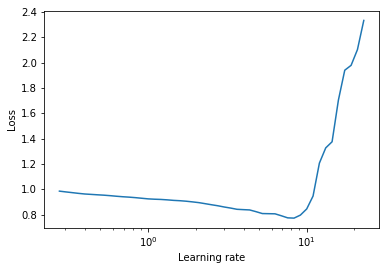

In [11]:
lr_finder = lr_finder.LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(train_dl, end_lr=1000, num_iter=100)
lr_finder.reset()
lr_finder.plot()

In [12]:
def parametrify(param):
    param =  str(param)
    param = param.replace('\n', '').replace('\r', '')
    return param

In [15]:
mlflow.set_experiment('Sin')
with mlflow.start_run(nested=True):
    mlflow.log_param("lr", lr)
    mlflow.log_param("epoch_size", epoch_size)
    mlflow.log_param("batch_size", batch_size)
    mlflow.log_param("num_param", num_param)
    mlflow.log_param("criterion", parametrify(criterion))
    mlflow.log_param("num_epoch", num_epoch)
    mlflow.log_param("scheduler", parametrify(scheduler))
    
    model = train_model(model, dataloaders, criterion, optimizer, scheduler=scheduler, num_epochs=num_epoch)
    
    for epoch, loss in enumerate(model.recorder['train']['loss']):
        mlflow.log_metric("train_loss", loss, step=epoch)
    for epoch, loss in enumerate(model.recorder['val']['loss']):
        mlflow.log_metric("val_loss", loss, step=epoch)
        
    for step, loss in enumerate(model.recorder['train']['lr']):
        mlflow.log_metric("lr", loss, step=step)

    mlflow.pytorch.log_model(model, 'models')

Training complete in 4m 15s


/home/alexis/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type CNN_model. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/alexis/anaconda3/envs/fastai/lib/python3.7/site-packages/torch/serialization.py:251: UserWarning: Couldn't retrieve source code for container of type ChannelLinear. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


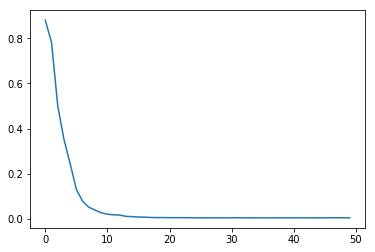

In [16]:
plt.plot(model.recorder['train']['loss'])
plt.show()

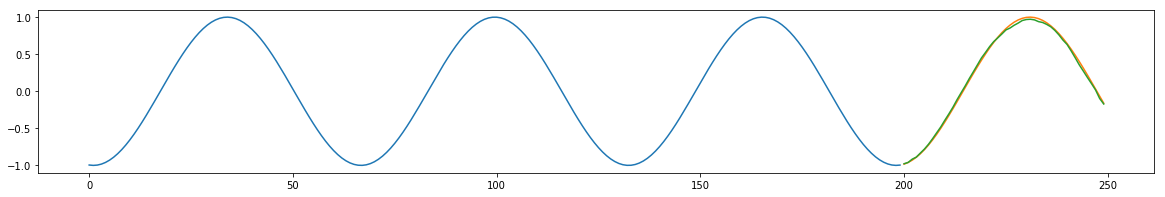

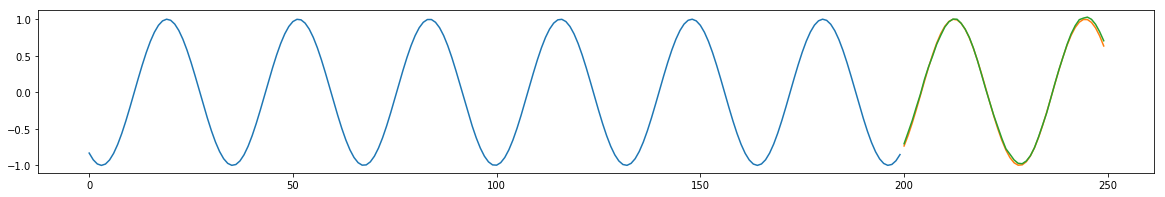

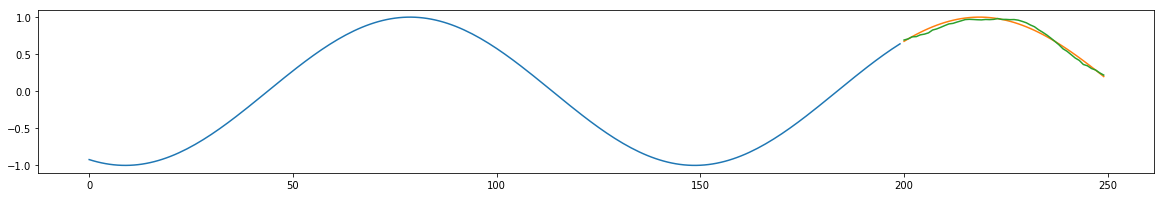

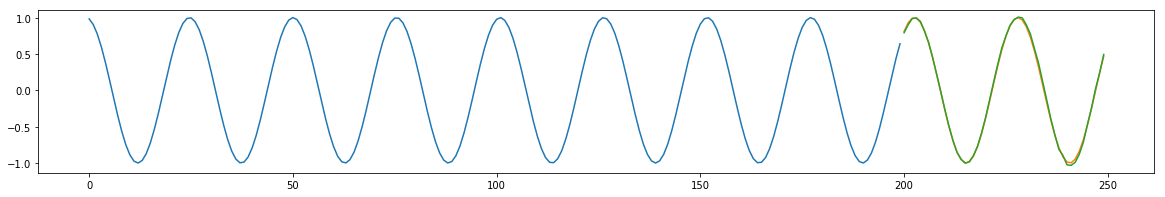

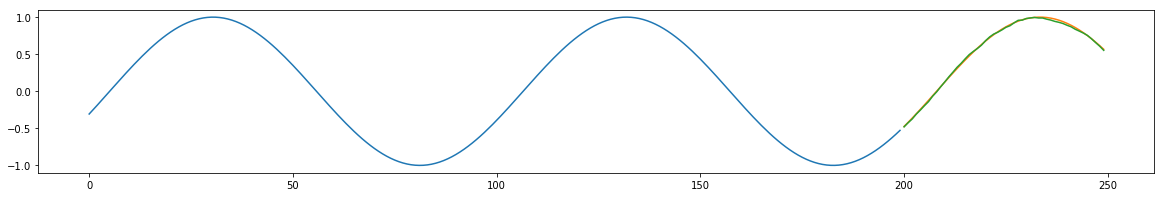

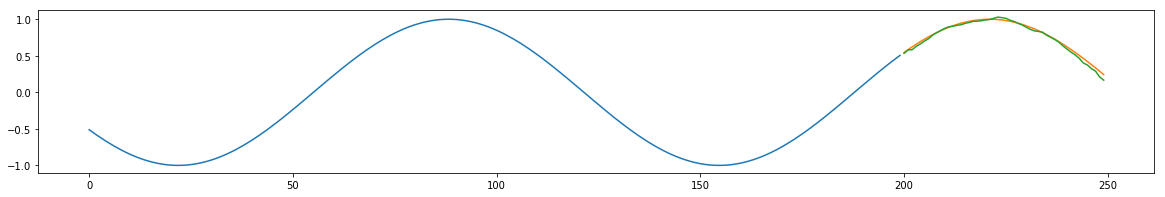

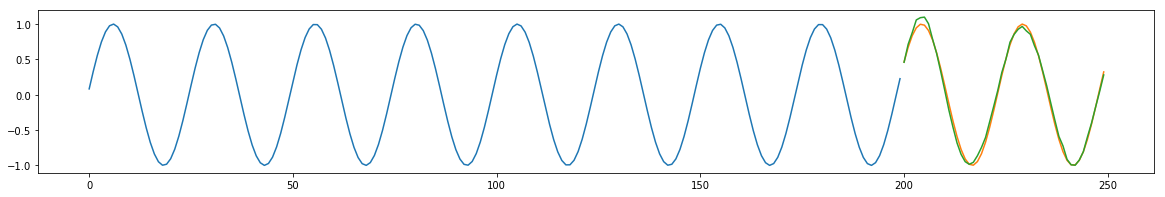

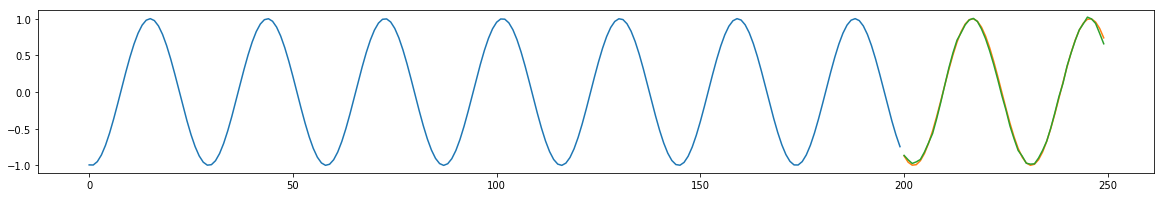

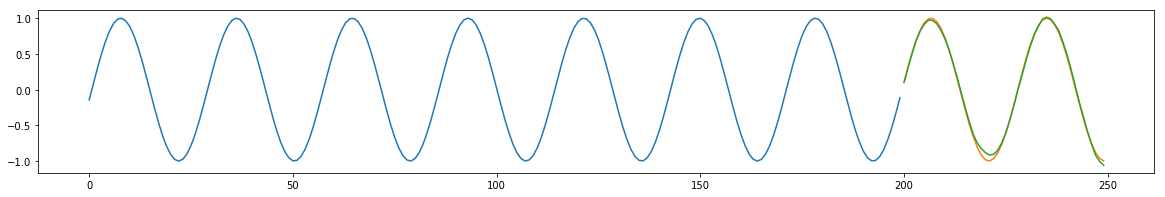

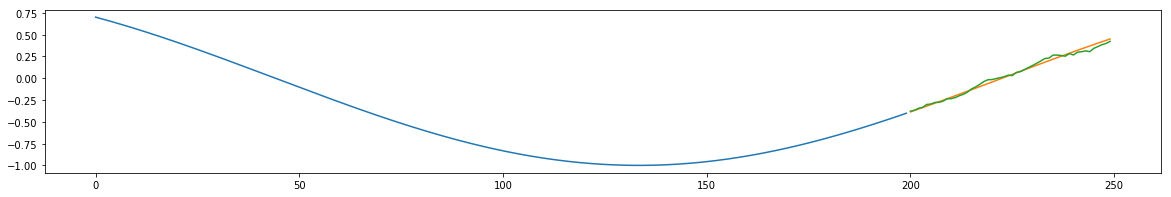

In [23]:
for i in range(10):
    data, label = train_ds[i]
    data, label = data[None, ...].cpu(), label[None, ...].cpu()
    with torch.set_grad_enabled(False):
        preds = model.eval()(data.to(device)).cpu().numpy()
    data, label = data.numpy(), label.numpy()

    fig, axs = plt.subplots(data.shape[1], figsize=(20,3), squeeze=False)
    for idx, ax in enumerate(axs.reshape(-1)):
        ax.plot(data[0,idx,:])
        ax.plot(np.arange(label.shape[2])+data.shape[2], label[0,idx,:])
        ax.plot(np.arange(label.shape[2])+data.shape[2], preds[0,idx,:])